In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetEncoder(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetEncoder, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(128 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class ResNetDecoder(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetDecoder, self).__init__()
        self.in_planes = 128 * block.expansion

        self.linear = nn.Linear(num_classes, 128 * block.expansion)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, upsample=True)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, upsample=True)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, upsample=False)
        self.conv1 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride, upsample):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
            self.in_planes = planes * block.expansion
        if upsample:
            layers.append(nn.ConvTranspose2d(self.in_planes, self.in_planes, kernel_size=2, stride=stride, padding=0, output_padding=0))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear(x)
        out = out.view(out.size(0), 128, 1, 1)  # 这里假设num_classes是10
        out = F.interpolate(out, scale_factor=8)  # 调整 scale factor 以匹配编码器的下采样
        out = self.layer3(out)
        out = self.layer2(out)
        out = self.layer1(out)
        out = self.conv1(out)
        return out


In [12]:
# 设置
batch_size = 64
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
root = '../datasets'

# 数据预处理，仅包括转换为Tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(root, train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

# 实例化模型
encoder = ResNetEncoder(BasicBlock, [2, 2, 2, 2]).to(device)
decoder = ResNetDecoder(BasicBlock, [2, 2, 2, 2]).to(device)

# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        encoded_outputs = encoder(inputs)
        decoded_outputs = decoder(encoded_outputs)
        loss = criterion(decoded_outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


Using cuda device
Files already downloaded and verified
Epoch [1/30], Average Loss: 0.0552
Epoch [2/30], Average Loss: 0.0275
Epoch [3/30], Average Loss: 0.0243
Epoch [4/30], Average Loss: 0.0253
Epoch [5/30], Average Loss: 0.0237
Epoch [6/30], Average Loss: 0.0231
Epoch [7/30], Average Loss: 0.0230
Epoch [8/30], Average Loss: 0.0237
Epoch [9/30], Average Loss: 0.0226
Epoch [10/30], Average Loss: 0.0223
Epoch [11/30], Average Loss: 0.0222
Epoch [12/30], Average Loss: 0.0220
Epoch [13/30], Average Loss: 0.0219
Epoch [14/30], Average Loss: 0.0219
Epoch [15/30], Average Loss: 0.0217
Epoch [16/30], Average Loss: 0.0218
Epoch [17/30], Average Loss: 0.0215
Epoch [18/30], Average Loss: 0.0215
Epoch [19/30], Average Loss: 0.0214
Epoch [20/30], Average Loss: 0.0217
Epoch [21/30], Average Loss: 0.0213
Epoch [22/30], Average Loss: 0.0212
Epoch [23/30], Average Loss: 0.0212
Epoch [24/30], Average Loss: 0.0211
Epoch [25/30], Average Loss: 0.0210
Epoch [26/30], Average Loss: 0.0209
Epoch [27/30], Av

In [13]:
# 创建保存模型的目录（如果它还不存在）
model_dir = '../model/resnet_cifar'
os.makedirs(model_dir, exist_ok=True)

# 保存模型状态字典
torch.save(encoder.state_dict(), os.path.join(model_dir, 'encoder.pth'))
torch.save(decoder.state_dict(), os.path.join(model_dir, 'decoder.pth'))

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


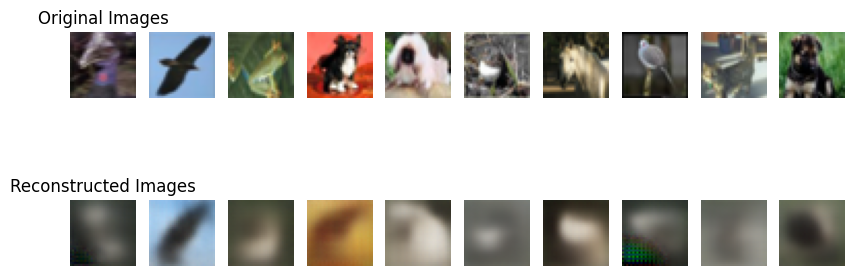

In [14]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化并加载模型
encoder = ResNetEncoder(BasicBlock, [2, 2, 2, 2]).to(device)
decoder = ResNetDecoder(BasicBlock, [2, 2, 2, 2]).to(device)
model_dir = '../model/resnet_cifar'

encoder.load_state_dict(torch.load(os.path.join(model_dir, 'encoder.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(model_dir, 'decoder.pth'), map_location=device))

# 将模型设置为评估模式
encoder.eval()
decoder.eval()

# 加载 CIFAR-10 测试数据集
test_dataset = datasets.CIFAR10(root='../datasets', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# 从数据加载器中获取一批数据
data_iter = iter(test_loader)
images, _ = next(data_iter)

# 将图像移动到设备上
images = images.to(device)

# 使用编码器和解码器
with torch.no_grad():
    encoded_imgs = encoder(images)
    decoded_imgs = decoder(encoded_imgs)

# 将图像移动回CPU
images = images.cpu()
decoded_imgs = decoded_imgs.cpu()

# 绘制原始图像和重建图像
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
for i in range(10):
    # 显示原始图像
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0))
    ax.axis('off')

    # 显示重建图像
    ax = axes[1, i]
    ax.imshow(decoded_imgs[i].permute(1, 2, 0))
    ax.axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')
plt.show()
